In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

In [9]:
def cell_format(num):
    if -1000 < num < 1000:
        return num
    
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.1f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


def fireplot(df, country, start_time=None, most_recent=0, save=True, show=False, fontsize=30, labelsize=30, titlesize=56, show_sum=True, split=False):
    # trimming the df
    if start_time:
        df = df.iloc[df.index.get_loc(start_time):]
    else:
        df = df.iloc[np.argmax(df.sum(axis=1) >= 3):]
        if most_recent: # so that most_recent and start_time trimming cannot be activated simultaneouly
            df = df.iloc[-most_recent:,:]
    
    if type(df.index[-1]) != str:
        date = df.index[-1].strftime('%Y-%m-%d')
    else:
        date = df.index[-1]
    
    if split:
        dfs = []
        for i in range(len(df.columns)//split):
            dfs.append(df.iloc[:,i*split : (i+1)*split])
        if len(df.columns) % split:
            dfs.append(df.iloc[:,(i+1)*split : ])
        for i in range(len(dfs)):
            fireplot(dfs[i], country=country+'_'+str(i+1), split=False)
        return
    
    if show_sum:
        df.insert(loc=0, column='SUM', value=df.sum(axis=1))
        

    # main part, define color boundaries and colors
    w_ratio = 1.5 if df.max().max() < 1000 else 2.5
    fig, ax = plt.subplots(figsize=(int(df.shape[1]*w_ratio), df.shape[0]))

    cmap = colors.ListedColormap(['#38d738','#ffff00','#ff9900','#b45f06','#ff0000','#741b47'])
    bounds=[-100000,0.5,9.5,29.5,99.5,999.5,100000]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(df.fillna(0).values, cmap=cmap, norm=norm)

    # tick labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right', va='center', rotation_mode="anchor")
    
    # annotate, font color by cell bolor
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            cell = df.fillna(0).values[i, j]
            if cell:
                cell_c = 'w' if (cell >= 1000 or cell < 0) else 'k'
                cell_s = fontsize if (cell < 1000) else int(fontsize * 0.8)
                text = ax.text(j, i, cell_format(cell),
                               ha='center', va='center', color=cell_c, fontsize=cell_s)

#     ax.set_title('%s Fireplot'%country, fontsize=titlesize)
    ax.tick_params(labelsize=labelsize)
    fig.tight_layout()
    
    # output
    if save:
        plt.savefig(r'figures\fire/Fire_%s.png'%(country+'_'+date), dpi=100)
    if not show:
        plt.close()
    print(date)

# Global

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
focus = df.copy().drop(['Lat','Long'], axis=1).set_index(['Country/Region','Province/State'])
confirm = focus.groupby('Country/Region').sum()
confirm.columns = pd.to_datetime(confirm.columns).strftime('%Y-%m-%d')
df = confirm.T.diff()

set_africa = {'South Africa','Algeria','Cameroon','Burkina Faso','Cote d\'Ivoire','Mauritius','Nigeria','Senegal','Ghana',
              'Niger','Congo (Kinshasa)','Kenya','Guinea','Rwanda','Madagascar','Uganda','Congo (Brazzaville)','Togo','Ethiopia','Zambia','Mali','Guinea-Bissau',
              'Eritrea','Tanzania','Benin','Gabon','Equatorial Guinea','Namibia','Angola','Liberia','Seychelles','Mozambique',
              'Eswatini','Zimbabwe','Central African Republic','Chad','Cabo Verde','Mauritania','Sierra Leone','Botswana','Gambia',
              'Malawi','Sao Tome and Principe','Burundi','South Sudan','Western Sahara','Comoros','Lesotho'}
set_america = {'US','Canada','Brazil','Chile','Ecuador','Peru','Mexico','Panama','Dominican Republic','Argentina','Colombia',
               'Costa Rica','Uruguay','Cuba','Honduras','Bolivia','Venezuela','Paraguay','Trinidad and Tobago','Guatemala','El Salvador',
               'Jamaica','Barbados','Bahamas','Guyana','Haiti','Antigua and Barbuda','Dominica','Saint Lucia','Grenada','Suriname',
               'Saint Kitts and Nevis','Belize','Saint Vincent and the Grenadines','Nicaragua',}
set_asia = {'China','Korea, South','Australia','Japan','Malaysia','Philippines','Singapore','New Zealand','Vietnam','Brunei',
            'Cambodia','Mongolia','Fiji','Laos','Papua New Guinea','India','Indonesia','Thailand','Sri Lanka','Bangladesh',
            'Burma','Maldives','Nepal','Bhutan','Timor-Leste','Tajikistan'}
set_europe = {'Spain','Italy','Germany','France','United Kingdom','Switzerland','Belgium','Netherlands','Austria','Portugal',
              'Israel','Sweden','Russia','Norway','Ireland','Czechia','Denmark','Poland','Romania','Luxembourg','Serbia','Finland',
              'Greece','Iceland','Ukraine','Croatia','Estonia','Slovenia','Moldova','Lithuania','Armenia','Hungary','Belarus',
              'Bosnia and Herzegovina','Kazakhstan','Azerbaijan','North Macedonia','Bulgaria','Latvia','Andorra','Slovakia',
              'Uzbekistan','Cyprus','Albania','San Marino','Malta','Kyrgyzstan','Montenegro','Georgia','Liechtenstein','Monaco',
              'Holy See','Kosovo'}
set_middle_east = {'Iran','Turkey','Pakistan','Saudi Arabia','United Arab Emirates','Qatar','Egypt','Morocco','Iraq','Bahrain','Kuwait',
                   'Tunisia','Lebanon','Oman','Afghanistan','Jordan','Djibouti','Syria','Libya','Sudan','Somalia','West Bank and Gaza',
                  'Yemen'}


fire = df.fillna(0).astype(int)
fire = fire[fire.sum().sort_values(ascending=False).index]
fire_asia = fire[[i for i in fire.columns if i in set_asia]]
fire_middle_east = fire[[i for i in fire.columns if i in set_middle_east]]
fire_europe = fire[[i for i in fire.columns if i in set_europe]]
fire_africa = fire[[i for i in fire.columns if i in set_africa]]
fire_america = fire[[i for i in fire.columns if i in set_america]]
fire = fire_asia.join(fire_middle_east).join(fire_africa).join(fire_europe).join(fire_america)


fireplot(fire, country='Global', split=35)

2020-05-28
2020-05-28
2020-05-28
2020-05-28
2020-05-28
2020-05-28


# Countries

## US

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df = df.pivot(index='date',columns='state',values='cases').iloc[32:]
df = df[df.iloc[-1].sort_values(ascending=False).index].diff()
df.index.rename('US', inplace=True)
df = df.fillna(0).astype(int)

fireplot(df, country='US', split=35)

2020-05-28
2020-05-28


## Brazil

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
df = df.pivot_table(index='date',columns='state',values='newCases').fillna(0).drop('TOTAL',axis=1).fillna(0).astype(int)
df = df[df.sum().sort_values(ascending=False).index]

fireplot(df, country='Brazil')

2020-05-29


## Russia

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/PhtRaveller/covid19-ru/master/data/covid_stats.csv')
df = df.query('category=="total"').drop(['category',
                                         'Наблюдение (всего)',
                                         'Россия - сумма по регионам',
                                         'Россия',
                                         'Наблюдение'], axis=1)
df.date = pd.to_datetime(df.date).dt.strftime('%Y-%m-%d')
df.set_index('date', inplace=True)
df = df.diff().fillna(0).astype(int)
df = df[df.sum().sort_values(ascending=False).index]

fireplot(df, country='Russia', split=50)

2020-05-29
2020-05-29


## Spain

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/Secuoyas-Experience/covid-19-es/master/datos-comunidades-csv/covid-19-ES-CCAA-DatosCasos.csv')
df = df.pivot_table(index='fecha', columns='nombreCcaa', values='casosConfirmados').diff().fillna(0).astype(int)
df = df[df.sum().sort_values(ascending=False).index]

fireplot(df, country='Spain')

2020-05-28


## UK

In [517]:
# only public lab results, less than total
df = pd.read_csv('https://raw.githubusercontent.com/tomwhite/covid-19-uk-data/master/data/covid-19-cases-uk.csv')
df['Area_full'] = df['Country'] + '-' + df['Area']
df = df.pivot_table(index='Date', columns='Area_full', values='TotalCases').diff().fillna(0).astype(int)
df = df[df.sum().sort_values(ascending=False).index]

fireplot(df, country='UK')

2020-05-28


## Italy

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
df.data = df.data.apply(lambda i:i.split('T')[0])
# df.data = pd.to_datetime(df.data)
df = df.pivot_table(index='data',columns='denominazione_regione',values='nuovi_positivi')
df = df[df.sum().sort_values(ascending=False).index]

fireplot(df, country='Italy')

2020-05-29


## India

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/pratik-bose/CoronaTracker/V1/CoronaData.csv')
df = df.pivot_table(index='Date',columns='Name_1',values='TotalCases').diff().fillna(0).astype(int)
df = df[df.sum().sort_values(ascending=False).index]

fireplot(df, country='India')

2020-05-30


# US states

In [56]:
country = 'Wisconsin'
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df = df[df['state']==country]
df = df.pivot(index='date',columns='county',values='cases')
df = df[df.iloc[-1].sort_values(ascending=False).index].diff()
df.index.rename(country, inplace=True)
df = df.fillna(0).astype(int)
date = df.index[-1]

fireplot(df, country, split = 40)

2020-05-28
2020-05-28


In [145]:
# Batch generatate, takes some time to finish
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df = df.pivot(index='date',columns='state',values='cases').iloc[32:]
df = df[df.sum().sort_values(ascending=False).index]
states = list(df)

for country in states:
    df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
    df = df[df['state']==country]
    df = df.pivot(index='date',columns='county',values='cases')
    df = df[df.iloc[-1].sort_values(ascending=False).index].diff()
    df.index.rename(country, inplace=True)
    df = df.fillna(0).astype(int)
    date = df.index[-1]

    fireplot(df, country)    

# Experimental ground

ValueError: Image size of 66960x39600 pixels is too large. It must be less than 2^16 in each direction.

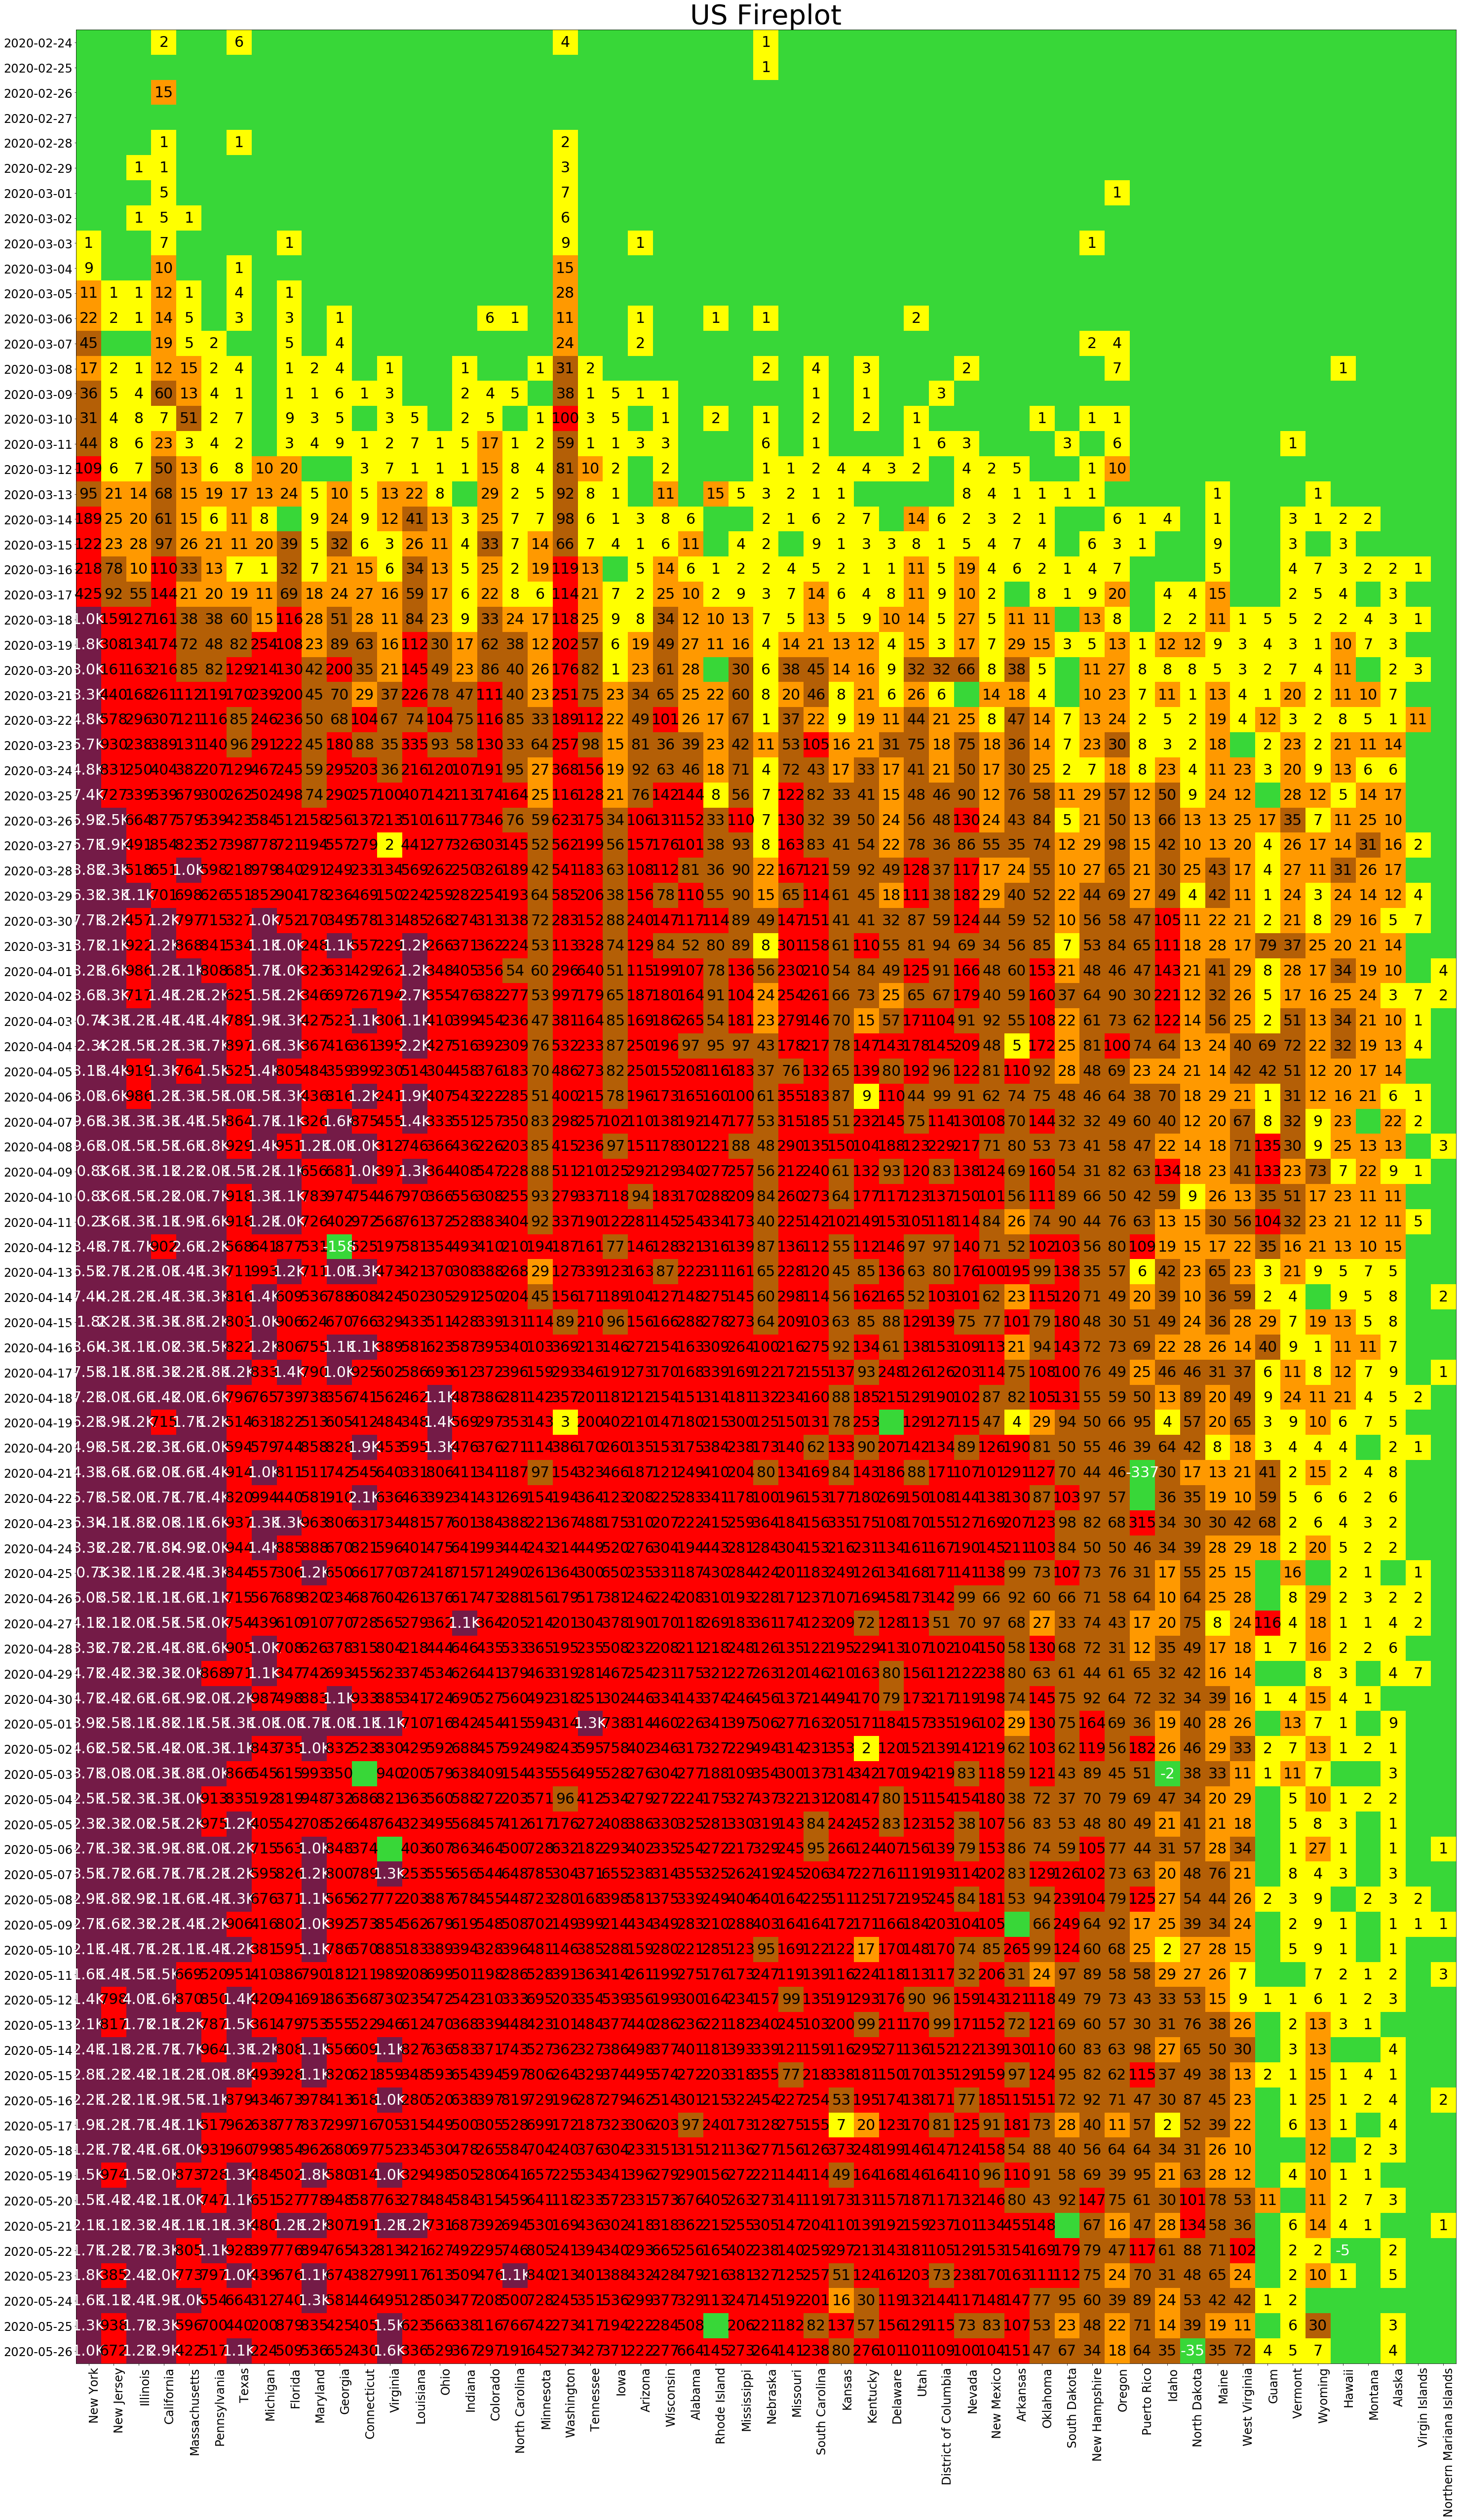

ValueError: Image size of 66960x39600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 66960x39600 with 1 Axes>

In [234]:
def fireplot(df, country, start_time=None, most_recent=0, w_ratio=1, h_ratio=1, save=True, show=False, fontsize=30, labelsize=30, titlesize=56):
    if start_time:
        df = df.iloc[df.index.get_loc(start_time):]
    else:
        df = df.iloc[np.argmax(df.sum(axis=1) >= 10):]
        if most_recent: # so that most_recent and start_time trimming cannot be activated simultaneouly
            df = df.iloc[-most_recent:,:]
    fig, ax = plt.subplots(figsize=(int(df.shape[0]*h_ratio), int(df.shape[1]*w_ratio*max(1, (80//df.shape[1])))))

    cmap = colors.ListedColormap(['#38d738','#ffff00','#ff9900','#b45f06','#ff0000','#741b47'])
    bounds=[-100000,0.5,9.5,29.5,99.5,999.5,100000]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    im = ax.imshow(df.fillna(0).values, cmap=cmap, norm=norm)

    ax.set_xticks(np.arange(len(df.columns)-0.5))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)


    plt.setp(ax.get_xticklabels(), rotation=90, ha='right', rotation_mode="anchor")

    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            cell = df.fillna(0).values[i, j]
            if cell:
                cell_c = 'w' if (cell >= 1000 or cell < 0) else 'k'
                text = ax.text(j, i, cell_format(cell),
                               ha='center', va='center', color=cell_c, fontsize=fontsize)

    ax.set_title('%s Fireplot'%country, fontsize=titlesize)
    ax.tick_params(labelsize=labelsize)
    fig.tight_layout()
    if save:
        plt.savefig('figures/Fire_%s.png'%(country+'_'+date), dpi=40)
    if not show:
        plt.close()
        
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df = df.pivot(index='date',columns='state',values='cases').iloc[32:]
df = df[df.iloc[-1].sort_values(ascending=False).index].diff()
df.index.rename('US', inplace=True)
df = df.fillna(0).astype(int)
fireplot(df, country = 'US', w_ratio=1.3, h_ratio=1.3, show=True)

fireplot(df, country, h_ratio=10, w_ratio=10, fontsize=24, labelsize=34,
#          , start_time='2020-02-27'
         show=True
        )